# Evaluate a Multinomial Logistic Classifier on the MNIST test set

This notebook shows how to load a previously trained model and use it to predict the labels of the MNIST test images.

Inputs:
 - Data: MNIST test dataset (image and true label)
 - Coefficients: tensors W and b leaded from a file saved by the training process.


Outputs:
 - Accuracy: quality of fit of the model over all the test set.
 - Error example: an image where the classifier makes a mistake (predicts the wrong label)

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/home/adrian/anaconda2/envs/deep/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Data Preparation

Below, we read the test dataset and define functions to preprocess or visualize the images.

In [2]:
# data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def get_mnist_image(ds):
    """
    Choose an image at random from the image dataset passed as parameter
    :param ds: dataset class (from MNIST input_data)
    :return ndarray [28, 28]
    """
    observation, label = ds.next_batch(1)
    return observation, label

In [4]:
def show_mnist_image(observation):
    image = observation[0].reshape(28, 28)
    #print observation[0].shape, image.shape    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=matplotlib.cm.Greys)

### Model Definition
The model is a basic multinomial logistic classifier, consisting of a linear matrix multiply and a softmax.
In this notebook we only need the prediction part of the model, so there is no need to define a loss function.

In [5]:
import tensorflow as tf
# Declare tensors to hold the model coefficients
W = tf.Variable(tf.zeros([784, 10]), name="W")
b = tf.Variable(tf.zeros([10]), name="b")

# Define the prediction formulas
x = tf.placeholder(tf.float32, [None, 784])
scores = tf.matmul(x, W) + b
y = tf.nn.softmax(scores)

#### Restore previously trained coefficients  and predict a randomly chosen digit from the test set
 - Restore all of session's variabls (tensors) back to a previous checkpoint.
 - Verify the accuracy of the coefficients loaded on the test data, we want 90% or more

In [6]:
modelpath = "model/train/"

def restore_model(sess, modelpath):
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(modelpath)
    if ckpt and ckpt.model_checkpoint_path:
      # Restores from checkpoint
      saver.restore(sess, ckpt.model_checkpoint_path)
      print "Model loaded"
    else:
      print "No checkpoint file found"

In [7]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver()
restore_model(sess, modelpath)

y_ = tf.placeholder(tf.float32, [None, 10])
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Trained model accuracy on test data: %g\n" % 
      sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

Model loaded
Trained model accuracy on test data: 0.9245



#### Predict digits from the test set
 - Randomply pick an image from the dataset and predict its label
 - Repeat until the classifier makes a mistake
 - Show labels and test image for the first classification error found

Correct predictions:  259

Predicted Label: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Actual Label: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
Cross Entropy: 6.79983


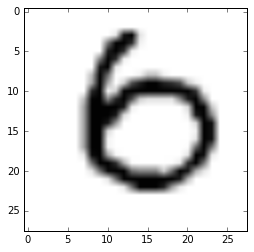

In [8]:
# Define a quality metric to be applied to the predictions 
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))

for k in range(500):
    observation, label = get_mnist_image(mnist.test)
    pred_label = [round(i) for i in sess.run(y, feed_dict={x: observation})[0]]
    missmatch = False
    for i in range(len(label)):
        if label[0][i] != pred_label[i]:
            missmatch = True
            break
    if missmatch:
        print "Correct predictions: ", k
        print
        if sum(pred_label) == 0:
            print "Scores:", ["%0.2f" % s for s in sess.run(scores, feed_dict={x: observation})[0]]
        print "Predicted Label:", pred_label
        print "Actual Label:",  label[0]
        print "Cross Entropy:",  sess.run(cross_entropy, feed_dict={y_: label, x: observation})
        show_mnist_image(observation)
        break

In [9]:
sess.close()